# Final assignment

## Instructions

- Read the instructions for the final assignment from the [course page](https://sustainability-gis.readthedocs.io/en/latest/lessons/final-assignment/final-assignment.html).
- To get help with Markdown formatting check [this page](https://www.markdownguide.org/cheat-sheet/).
- If you don't know how to add a Markdown cell check [this page](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook)

## Add your work below

Mix markdown cells with code cells regularly to explain and document your work / codes (in a similar manner as how the Exercises of this course were written). 
Below we provide you a suggestion for the structure of the report by listing the main components that would be good to include in your work. However, you do not necessarily need to follow this structure and you can adjust the headings as you see best.

## 1. Introduction

"The global attention to transport has continued in recent years. World leaders recognized unanimously at the 2012 United Nations Conference on Sustainable Development (Rio +20) that transportation and mobility are central to sustainable development. Sustainable transportation can enhance economic growth and improve accessibility. Sustainable transport achieves better integration of the economy while respecting the environment, improving social equity, health, resilience of cities, urban-rural linkages and productivity of rural areas" (https://sustainabledevelopment.un.org/index.php?page=view&type=502&nr=46&menu=61)

The United Nations' Sustainable Development Goal # 11 focuses on making cities and human settlements inclusive, safe, resilient, and sustainable. Many components make up a safe and sustainable city, but one that can ensure opportunities for human prosperity and life satisfaction is high quality transport systems. Sustainable transportation plays a vital role in creating a society where people can have freedom. Cities that create public transportation systems with the goal to provide 24/7 access for people to move, genereally feel safer, more inclusive, and provide greater opportunities in mobility, than cities that do not. Car-dependent cities do not provide opportunities for individuals to escape poverty as easily as cities that emphasize public transportation. Public transportation provides the possibility for people to travel to interviews and work without the costly investment of a private vehicle. Cities that are structured with public transportation also make it safer for pedestrians. As public transportation greatly increases foot traffic next to streets, roads are planned to be safe for people, and drivers are similarly aware of pedestrians as regular components of street networks. Thus introduces the first sub indicator of target 11.2 that will be analysed in the report; road traffic deaths per 100,000 population. 

"Road traffic accidents kill more than 1.2 million people every year and severe traffic congestion is choking cities" (UN Stats 2021 https://unstats.un.org/sdgs/metadata/files/Metadata-11-02-01.pdf). Road traffic deaths per 100,000 population give an idea on the level of private automobile usage in a city and the level of safety a city's road network has for pedestrians. The U.S. is particularly notorious for its overwhelming dependence on private vehicles and few metro areas with adequate public transport. Few cities in the U.S have adequate public transportation systems that do not solely rely on cars. Data from the National Highway Traffic and Safety Administration and the Federal Transit Administration finds that "large metro areas with higher levels of public transportation (more than 40 annual transit trips per capita) have lower traffic fatality rates than cities with fewer than 20 transit trips per capita" (Small, 2018 https://www.bloomberg.com/news/articles/2018-09-11/cities-with-good-public-transit-have-fewer-road-fatalities) For example, in cities like New York City and San Francisco with well established public transportation systems, there has been a 28 percent decrease and 41 percent decrease (respectively) in traffic fatalities from 2013 to 2017 (Ferrier 2018, https://visionzeronetwork.org/vision-zero-buoyed-by-progress/). However, the national level of road traffic fatalities that occur each year remain unimproved. In 2019 6,237 people pedestrians were struck and killed (Dangerous by Design 2021, https://smartgrowthamerica.org/dangerous-by-design/). The burden of these fatalities is largely unequal, with "older adults, people of color, and people walking in low-income communities disproportionately represented" (Dangerous by Design 2021). Low income communities typically bear the brunt of poorly designed cities as they are "significantly less likely to have sidewalks, marked crosswalks, or street design that supports safer, slower speeds" (Dangerous by Design 2012). 

Our second sub-indicator analysed in this project will be the percentage of population with access to public transporation with a frequency level of at least 20 minute intervals. Public transportation in the U.S. does exist to a certain level across the country, however the quality of the service can be inconsistent and faulty, due largely to the lack of investment made in the Transportation sector. Without consistent and reliable connections, the public transportation in many cities may as well not exist at all. For many American cities, public transporation does not extend far beyond the city center. Only in cities such as NYC or SF, public transportation comes in many forms that extends far and wide beyond the center. This report will cover two cities in the U.S, Austin, TX and Memphis, TN. Both Texas and Tennessee have their own unique issues when it comes to transportation infrastructre. In 2020, Texas ranked first in population gains from the previous year according to the US Census (Williamson, 2021). In 10 years it has grown by 16.4 percent. With this fast growing poulation, Texas is facing congestion issues as more and more people relocate to work there. However, solutions are largely focused on road expansion. Annually, Texans living in Austin spend roughly 52 excess hours stuck in traffic, costing about $1,159 per auto commuter (McPherson et. al, 2018). According to the Texas A&M Transportation Institute and Texas Department of Transportation, Interstate 35 in downtown Austin ranked as the number one most congested freeway in Texas (Begley, 2020). Strides are, however, being made in the city to expand public transportation in the city. 

Tennessee ranks fairly low nationally in investment into transporation infrastructure. Smart Growth America's Dangerous by Design project to bring awareness to unsafe cities reports Memphis, TN as the third most dangerous city for pedestrians in the U.S. (Dangerous by Design 2021, Pedestrian Danger Index). Only 0.6 percent of residents in the state use public transportation to get to work, compared to the national average of 4.9 (Bureau of Transportation Statistics, USDOT). Memphis, TN is where I spent four years studying for my bachelor's. My first two years I did not have a car and I was largely dependent on friends with cars in order to move around the city. Few areas were designed for pedestrians. The public transportation while existent, was unreliable, ineffective, and associated with poverty and danger. It was understood that only those with little monetary means would deign to use the bus system. In an exercise appointed by a summer internship I had the chance to experience the MATA system in order to understand the city of Memphis better. Most of the bus stops were marked with a singular pole, without a place to sit or with times marked for the bus schedule. The buses would arrive anywhere from 10-60 minutes behind the set schedule found online, and typically only came once every 60 minutes. 
In contrast, Austin, TX ranks as a city with one of the highest ridership levels in public transportation in Texas. During a spring break trip in college, I spent a week in the city with friends, largely getting around with buses and rail. Stops were marked with schedules and were easy to find, though were not always a safe distance from the road. Surprisingly, we were able to manage well with the city's transit system and felt comfortbale getting around. In recent year, Austin has been making headlines as a growing city with an expanding public transit system. 

However, in both cities I saw friends endangered by unsafe road networks. In 2017, a friend driving a moped was hit by an empty charter bus in Austin, TX and was killed on impact. One year prior a friend biking in Memphis in the bike lane was run off the road by a large truck and was taken to the hospital. The unsafe, unsustainable, and unresilient roadways of the U.S. are a danger to its residents and an obstacle in many americans' path to prosperity. 

Many metropolitan cities in the U.S. are far from reaching the UN's SDG's especially concerning their development of safe, inclusive, and sustainable road networks for all. My analysis will compare the city of Austin and Memphis, with attention to road traffic fatalities, frequency of public transit, and the percentage of population within 500m of a public transit stop. 


- Preliminary research:
- Memphis: 150 deaths in 2019 / 651,932 total population = 23 deaths per 100,000
- Austin: 86 deaths in 2019 / 935,755 total population = 9.2 deaths per 100,000

## 2. Data and methods

Describe your data (list also the used data sources) and give an overview of the methods that you use in your work.

Data sources for Crash Reports and Fatality Locations: 
- data.austintexas.gov
- TN Department of Safety & Homeland Security 
- TITAN Fatal Crash Locations

Data sources for Public Transit:
- General Transit Feed Specification data (GTFS) fetched from Transitland

Data source for US 100m Population Grid:
- dataverse.harvard.edu

Traffic fatality data for Austin, TX involved searching data.austintexas.gov for most recent traffic fatality records that was recorded as a csv. This is fetched using Socrata from sodapy. Data for Memphis, TN was not available beyond a county level other than an online interactive map at https://tntrafficsafety.org/titan-fatal-crash-locations. Data could not be downloaded from the map directly nor scraped, though numerous methods were attemped through Postman, Parsehub and a TableuWebScraper plugin created on Github. Crash locations were therefore obtained by downloading an image of the map and using QGIS' Georeferencing tool to manually record each point in a shapefile. Data from the interactive map for each point was recorded as well, such as date, number of fatalities, and whether or not a pedestrian was involved. Data for public transit routes were downloaded from Transitland, an open data platfrorm that collects general transit feed specification data for cities around the world. Frequency of routes was collected manaually from each cities respective public transit schedules and uploaded as additional textfiles into the folder. Data for the 100m population grid was downloaded from Harvard's dataverse that provided tif files for the entire US. The tif was clipped to focus on my focus cities in QGIS and uploaded into JupyterLab.

### Data Processing and Analysis

In [2]:
# Import all necessary plugins
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from pyproj import CRS
import rasterio
import os
import numpy as np
from rasterio.plot import show
from rasterio.features import shapes
# run 'pip install cenpy' in terminal
from cenpy import products
import matplotlib.pyplot as plt

In [22]:
# Read in the data 
mem_df = pd.read_csv('data/Memphis_TN_transitfeed/stops.txt', delimiter = ",")
austin_df = pd.read_csv('data/Austin_TX_Transitland/stops.txt', delimiter = ",")
stop_times_mem = pd.read_csv('data/Memphis_TN_transitfeed/stop_times.txt', delimiter = ",")
stop_times_aust = pd.read_csv('data/Austin_TX_Transitland/stop_times.txt', delimiter = ",")

In order for the timestamp data to be used in this file the data needs to be in a 00-23 format. Data between the two cities differed but both contained timestamps with 24:00 format. This was fixed with a find and replace all function in text files before uploading back into JupyterLab. Python was first attempted with email.utils parsedate, however as the timestamp did not come with a date index the plugin did not succeed. Additionally, the data for Austin contained timestamps with 25:00, 26:00 format that did not adhere to any common rules for timestamps so they were changed prior to being read in the code cells. 

In [25]:
# Define time column as DateTimeIndex
def datetime_tool(df):
    ## Function to allow for the string columns in stop_times dfs to be converted to datetime format
    df['arrival_time'] = df['arrival_time'].str.replace(' ', '0')
    #df['arrival_time'] = df['arrival_time'].str.replace(' ', '0')
    df['time'] = pd.to_datetime(df['arrival_time'], format = '%H:%M:%S') 
    
    return df


stop_times_mem = datetime_tool(stop_times_mem)
stop_times_aust = datetime_tool(stop_times_aust)

In the next few cells we will read the data from many textfiles containing geometric data for Austin and Memphis' public transport routes. Various functions will be used to define geometry columns, merge dataframes, and keep track of each route's time length. 

In [26]:
def points_geom(df):
    ''''''
    ## Create Points out of the lon and lat columns 
    ''''''
    # creating a geometry column 
    geometry = [Point(xy) for xy in zip((df.filter(regex='_lon$')).squeeze(), 
                                        (df.filter(regex='_lat$',axis=1)).squeeze())]
    # Coordinate reference system : WGS84
    crs = CRS("WGS84")
    # Creating a Geographic data frame 
    df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return df
    
stops_mem = points_geom(mem_df)
stops_austin = points_geom(austin_df)

In [59]:
# Merge geographic data frame of stops with df on stop times 
def timing_stops(gdf, df):
    ## Merge dataframes on stop_id column
    timed = pd.merge(gdf, df, on = 'stop_id', how = 'left')
    return timed


timed_mem = timing_stops(stops_mem, stop_times_mem)
timed_aust = timing_stops(stops_austin, stop_times_aust)

In [28]:
# Read in spatial bus route data
shapes = pd.read_csv('data/Memphis_TN_transitfeed/shapes.txt', delimiter = ",")
shapes_austin = pd.read_csv('data/Austin_TX_Transitland/shapes.txt', delimiter = ",")
# Run the dataframe through the points function to create a geometry column for dataframe
mem_sh = points_geom(shapes)
austin_sh = points_geom(shapes_austin)

In [29]:
def linestrings_geom(gdf):
    # Function for creating linestrings out of our public transit route data

    # group by shape_id then transform into linestrings
    grouped = gdf.groupby("shape_id")['geometry'].apply(lambda x: LineString(x.tolist()))
    # Transform GeoSeries into GeoDataFrame
    routes = gpd.GeoDataFrame(grouped)
    # Reset index to access the ID number column of the routes
    routes = routes.reset_index()
    # Create another grouping and use concat to merge linestrings and keep distance traveled column
    g = gdf.groupby("shape_id")
    dist = (pd.concat([g.tail(1).drop(columns = 'geometry')])
       .drop_duplicates()
       .sort_values('shape_id')
       .reset_index(drop=True))

    route_dist = pd.merge(routes, dist, on = 'shape_id')
    return route_dist
    
routes_mem = linestrings_geom(mem_sh)
routes_austin = linestrings_geom(austin_sh)

In [30]:
# Read in bus trip data
trips_m = pd.read_csv('data/Memphis_TN_transitfeed/trips.txt', delimiter = ",")
trips_a = pd.read_csv('data/Austin_TX_Transitland/trips.txt', delimiter = ",")

def merge_dfs(gdf, df):
    
    ## Merge the dataframe with route linestrings with the df with routes id numbers and create Multilinestrings
    ## of each route
    
    trip_gdf = pd.merge(gdf, df[['route_id', 'shape_id']], on = 'shape_id', how = 'left')
    
    trip_gdf = trip_gdf.reset_index(drop = True)
    trip_gdf = gpd.GeoDataFrame(trip_gdf)
    # Remove duplicates of polygons in the df
    trip_gdf_dup = trip_gdf[~trip_gdf.duplicated(keep='first')]
    # Create another grouping and use concat to merge linestrings and keep distance traveled column
    g = trip_gdf_dup.groupby("route_id")
    dist = g['shape_dist_traveled'].sum()
    
    # Group by route_id then transform into Multilinestrings
    grouped = trip_gdf.groupby("route_id")['geometry'].apply(lambda x: MultiLineString(x.tolist()))
    # Transform GeoSeries into GeoDataFrame
    routes2 = gpd.GeoDataFrame(grouped)
    # Append the series of distance traveled as a separate column
    routes2['dist_traveled'] = dist 
    routes_gdf = routes2.reset_index()
    return routes_gdf
   
mem_routes = merge_dfs(routes_mem, trips_m)
aust_routes = merge_dfs(routes_austin, trips_a)

In [34]:
# Read in bus route and frequency of routes files
# and run two joins in order to gather all variables necessary for the bus routes
routes_m = pd.read_csv('data/Memphis_TN_transitfeed/routes.txt', delimiter = ",")
mata_freq = pd.read_csv('data/Memphis_TN_transitfeed/MATA_frequency.txt', delimiter = ",")
routes_a = pd.read_csv('data/Austin_TX_Transitland/routes.txt', delimiter = ",")
aust_freq = pd.read_csv('data/Austin_TX_Transitland/CAPMETRO_frequency.txt', delimiter = ",")

def pt_routes(gdf_routes, names, freq):
    
    ## Join dataframes in order to give a route name to each multilinestring of the route
    ## Then merge each named route with the frequency level of that route according to the online schedule 
    ## Set a CRS
    
    named = pd.merge(gdf_routes, names[['route_id', 'route_short_name', 'route_long_name']], 
                    on = 'route_id', how = 'left')
    routed = pd.merge(named, freq, on = 'route_short_name')
    routed = routed.set_crs(CRS("WGS84"))
    
    return routed

# Call function
mata = pt_routes(mem_routes, routes_m, mata_freq)
capmetro = pt_routes(aust_routes, routes_a, aust_freq)

In [35]:
def freq_level(df):
    ## Function for adding frequency labels based on avg minute frequencies of PT routes 
    freq_level = []
    for idx, row in df.iterrows():
        if row['avg_min_frequency'] >= 60:
            freq_level.append('LOW')
        elif row['avg_min_frequency'] > 20 and row['avg_min_frequency'] < 60:
            freq_level.append('MED')
        else:
            freq_level.append('HIGH')
        
    df['freq_level'] = freq_level
    return df

mata = freq_level(mata)
capmetro = freq_level(capmetro)

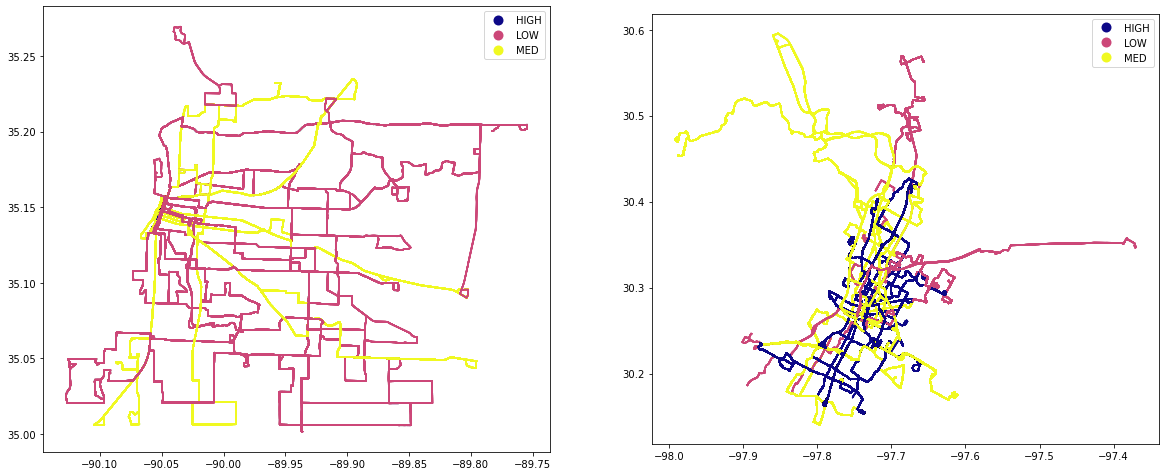

In [33]:
# Basic comparison between the two cities PT routes with their frequency level

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = mata.plot(ax=ax1, column='freq_level', legend=True, cmap = 'plasma')
ax2 = capmetro.plot(ax=ax2, column='freq_level', legend=True, cmap = 'plasma')

## 3. Data analysis + Results

Add and explain your analysis workflow below here.

In [17]:
from rasterio.features import shapes

def raster_processing(path):
    ## Transfrom Raster into Shapefile 
    fp = os.path.join(path)
    # Open the file:
    raster = rasterio.open(fp)
    # Transform the raster into a shapefile
    # https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons/187883

    mask = None
    with rasterio.Env():
            image = raster.read() # first band
            results = ({'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(image, mask=mask, transform=raster.transform)))

    geoms = list(results)
    pop_grid  = gpd.GeoDataFrame.from_features(geoms)
    pop_grid = pop_grid.drop((pop_grid.index[pop_grid['raster_val'] <= 0]))
    
    # Rename for a more intuitive meaning
    pop_grid = pop_grid.rename(columns = {"raster_val":"pop_cnt"})
    # Define the CRS
    pop_grid = pop_grid.set_crs("EPSG:4326")
    
    return pop_grid

# Two population grids from Harvard with 100m grid resolution
shelby_grid = raster_processing("data/100m_grid_mem.tif")
travis_grid = raster_processing("data/austin_tx_tif.tif")

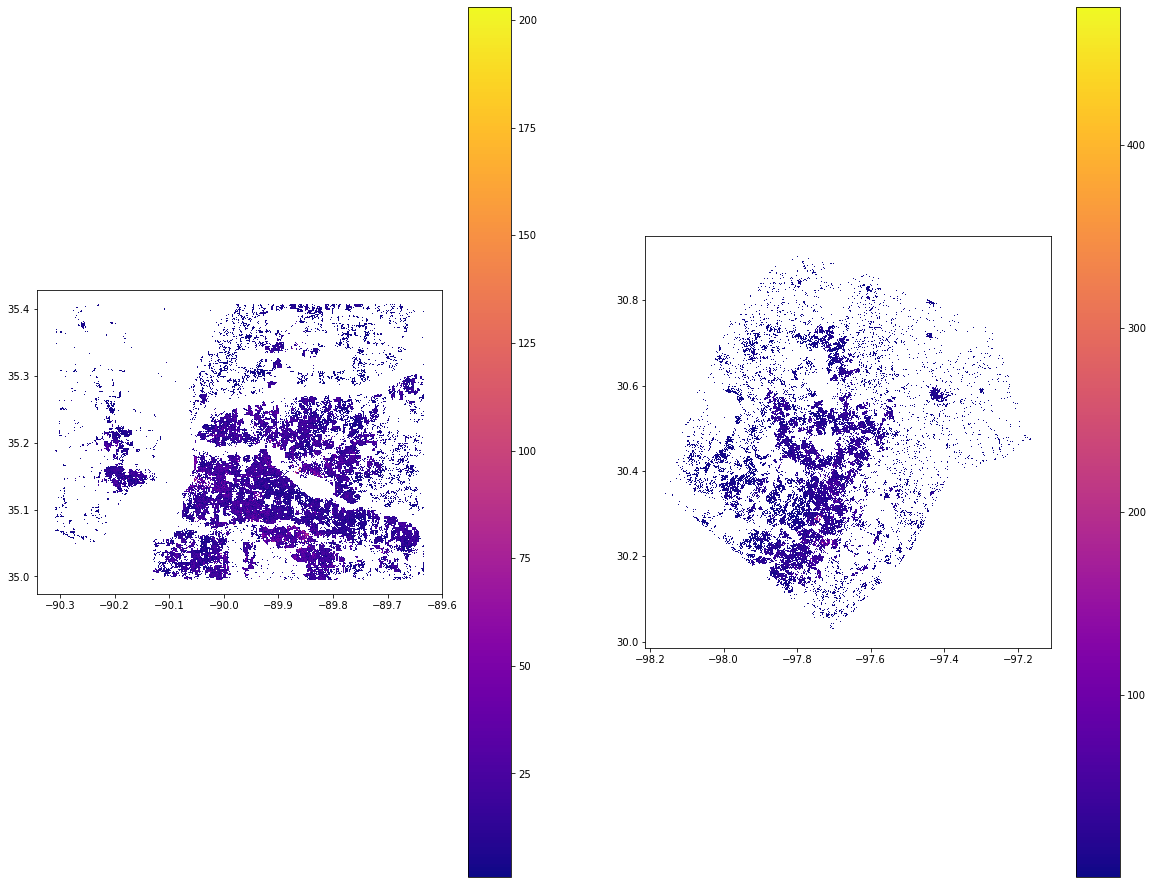

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = shelby_grid.plot(ax=ax1, column='pop_cnt', legend=True, cmap = 'plasma')
ax2 = travis_grid.plot(ax=ax2, column='pop_cnt', legend=True, cmap = 'plasma')

In [13]:
# run pip install cenpy 
from cenpy import products
import matplotlib.pyplot as plt
%matplotlib inline

dectest = products.Decennial2010()
mem_tn = dectest.from_county('Shelby, TN', 
                          level='block', 
                          variables=['P001001', 'P003003'])

/opt/conda/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
mem_tn = mem_tn.to_crs(CRS("WGS84"))

<AxesSubplot:>

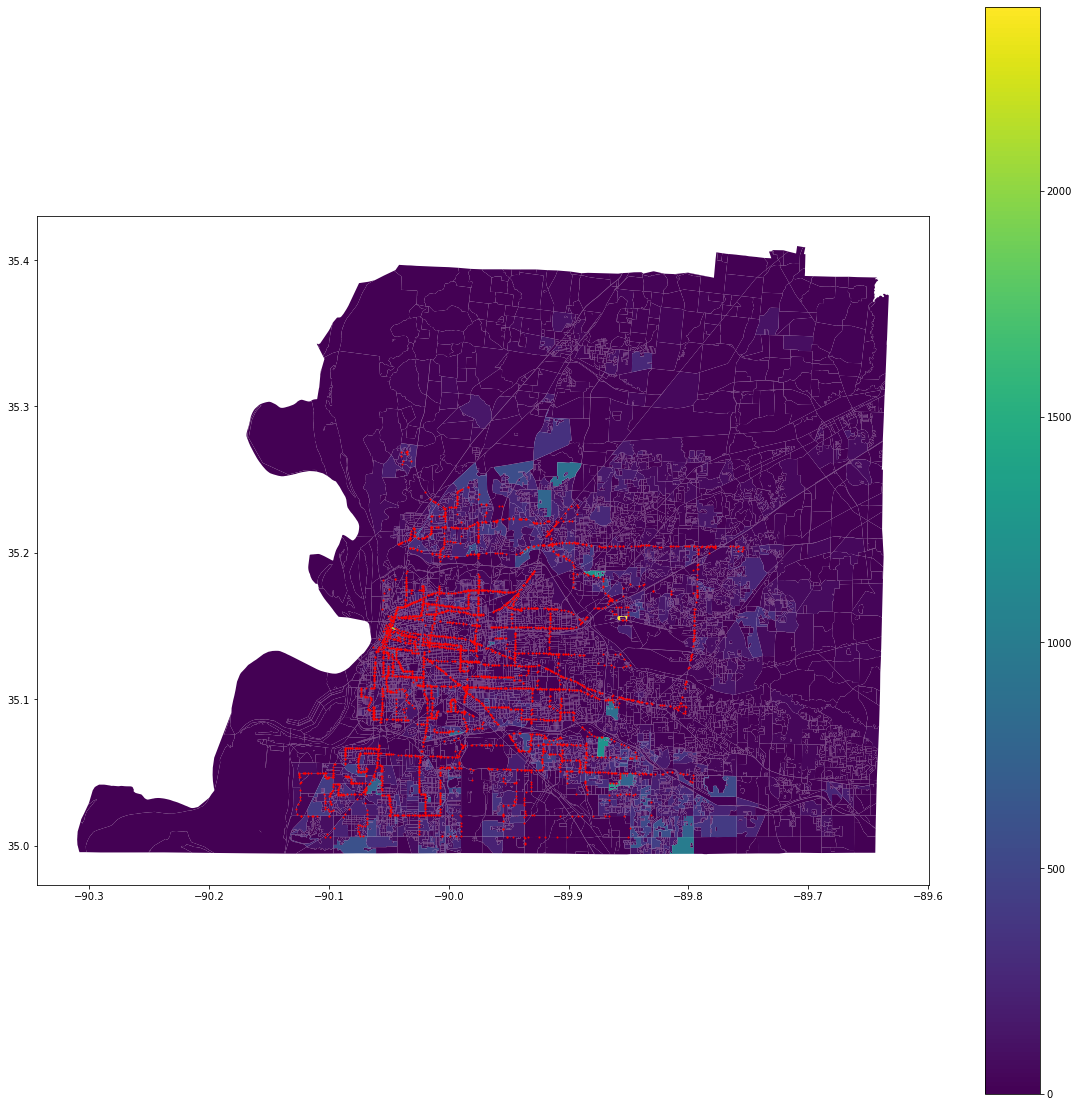

In [16]:
ax = mem_tn.plot('P003003', figsize = (20,20), legend = True)
stops_mem.plot(ax = ax, color = 'red', markersize = 1)

Create a 0.5 km buffer around each bus stops in order to assess percentage of population with access to the stop

In [17]:
def buffer_join(stops, grid):
    # create 500 meter buffers around bus stops
    # Reproject dataframe to one with meters instead of degrees
    stops = stops.to_crs(epsg=3395)
    buffer = stops.buffer(500, cap_style=1)
    # Transform Buffer GeoSeries into GeoDataFrame
    service_areas = gpd.GeoDataFrame(buffer)
    service_areas['geometry'] = service_areas[0]
    # Define the CRS in order to transform to WGS 84 
    service_areas = service_areas.set_crs(epsg=3395)
    service_areas = service_areas.to_crs("EPSG:4326")
    
    # Create a join between the buffered bus stops and the population grid
    join_s = gpd.sjoin(grid, service_areas, how="inner", op="intersects")
    # Remove duplicates of polygons in the df
    join_s = join_s[~join_s.index.duplicated(keep='first')]
    # Check the dataframe
    return join_s


pop_access_mem = buffer_join(stops_mem, shelby_grid)
pop_access_aust = buffer_join(stops_austin, travis_grid)

<AxesSubplot:>

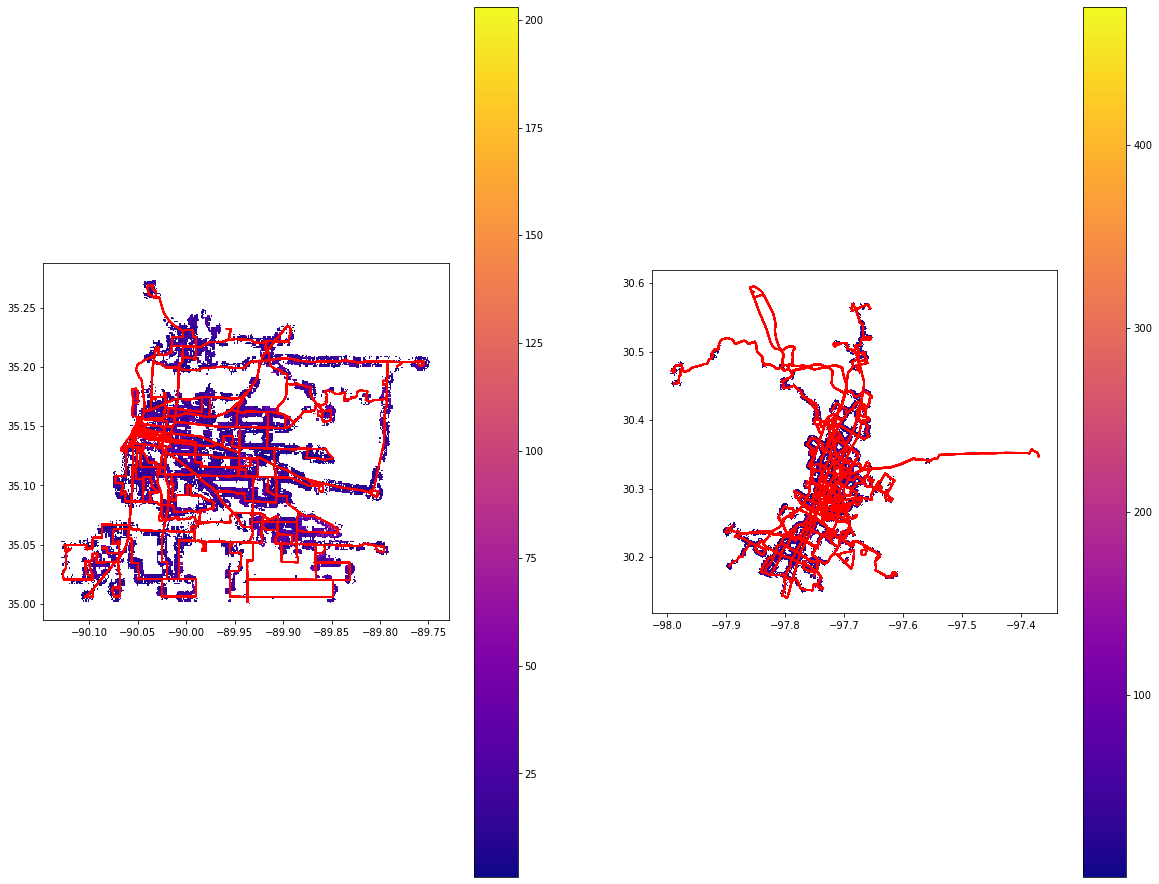

In [18]:
# Plot the data together
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = pop_access_mem.plot(ax=ax1, column='pop_cnt', legend=True, cmap = 'plasma')
ax2 = pop_access_aust.plot(ax=ax2, column='pop_cnt', legend=True, cmap = 'plasma')
mata.plot(ax = ax1, color = 'red')
capmetro.plot(ax = ax2, color = 'red')

In [19]:
print("Population in Memphis within 0.5km of a bus stop:","%.2f" %((pop_access_mem['pop_cnt'].sum())/(shelby_grid['pop_cnt'].sum())))
print("Population in Austin within 0.5km of a bus stop:","%.2f" %((pop_access_aust['pop_cnt'].sum())/(travis_grid['pop_cnt'].sum())))


Population in Memphis within 0.5km of a bus stop: 0.46
Population in Austin within 0.5km of a bus stop: 0.37


<AxesSubplot:>

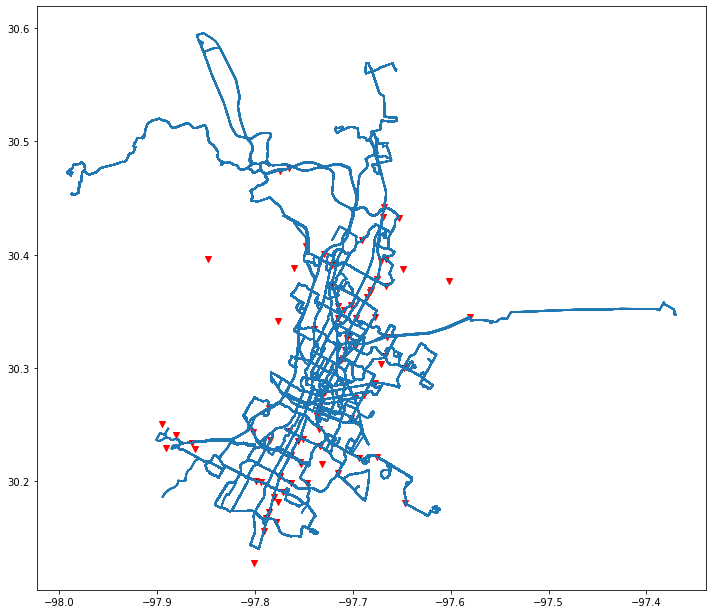

In [22]:
# Read in data for crash locations
A_crash_stats = gpd.read_file("data/crash_stats_Austin.shp")
M_crash_stats = gpd.read_file("data/Memphis_Crash_Locations.shp")

In [60]:
timed_mem['time'] = pd.DatetimeIndex(timed_mem['time'])
timed_mem.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,...,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,time
0,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,...,541832,08:18:19,8:18:19,4,NaN,0,0,1.5792,0,1900-01-01 08:18:19
1,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,...,541834,09:18:19,9:18:19,4,NaN,0,0,1.5792,0,1900-01-01 09:18:19
2,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,...,541836,10:18:19,10:18:19,4,NaN,0,0,1.5792,0,1900-01-01 10:18:19
3,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,...,541838,11:18:19,11:18:19,4,NaN,0,0,1.5792,0,1900-01-01 11:18:19
4,6,YALCOVWM,YALE@COVINGTON PIKE,YALE RD & CONNECTING RD,35.221558,-89.897067,NaN,NaN,NaN,NaN,...,541840,12:18:19,12:18:19,4,NaN,0,0,1.5792,0,1900-01-01 12:18:19


In [61]:
timed_mem['geometry']

0         POINT (-89.89707 35.22156)
1         POINT (-89.89707 35.22156)
2         POINT (-89.89707 35.22156)
3         POINT (-89.89707 35.22156)
4         POINT (-89.89707 35.22156)
                     ...            
157257    POINT (-90.07638 35.03210)
157258    POINT (-90.07638 35.03210)
157259    POINT (-90.07638 35.03210)
157260    POINT (-90.07638 35.03210)
157261    POINT (-90.07638 35.03210)
Name: geometry, Length: 157262, dtype: geometry

### Visualization

In [62]:
from keplergl import KeplerGl

# Create a basemap 
m = KeplerGl(height=800, width=800)

# Render the map / interface
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=800)

In [63]:
# Add filter according to time column of the dataframe
# Set to a 20 min interval 
m.add_data(timed_mem)

In [64]:
m.save_to_html(file_name='data/MATA.html')

TypeError: Object of type Timestamp is not JSON serializable

## 4. Discussion

Add discussion here.

## 5. References

TN Department of Safety and Homeland Security
https://www.tn.gov/content/dam/tn/safety/documents/dailyfatalitybycounty2020.pdf

Austin TX Traffic Fatalities 
https://www.austintexas.gov/department/traffic-fatalities

Transportation Infrastructure
https://comptroller.texas.gov/economy/fiscal-notes/2018/may/transportation.php#:~:text=TxDOT's%20Texas%20Transportation%20Plan%202040,%2415%20billion%20annually%20through%202040.

Williamson, Texas tops population growth as U.S. demographics shift
https://www.bondbuyer.com/news/texas-tops-population-growth-as-u-s-demographics-shift#:~:text=The%20bureau's%20estimates%20put%20Texas,charts%20from%202019%20to%202020.&text=Since%20the%20last%20census%20in,is%20second%20to%20Utah's%2017.4%25.

### Data
